<a href="https://colab.research.google.com/github/ismoil27/computer_vision/blob/main/menu_detector_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print('Menu Detector!')

Menu Detector!


In [ ]:
# -------------------------
# Import Libraries
# -------------------------
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define Dataset Path

DATASET_PATH = '/content/drive/MyDrive/food101_dataset'
print('Dataset_path:', DATASET_PATH)



CUSTOM_CLASS_MAPPING = {
    "hamburger": "hamburger",
    "hot_dog": "hot_dog",
    "chocolate_cake": "dessert", # label grouping | class consolidation
    "cheesecake": "dessert",     # label grouping | class consolidation
    "kebab": "kebab",
    "pilaf": "pilaf"
}



CLASSES = ['hamburger', 'hot_dog', 'dessert', 'kebab', 'pilaf']
CLASS_TO_IDX = {cls: i for i, cls in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

print(NUM_CLASSES)
print(CLASS_TO_IDX)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

Dataset_path: /content/drive/MyDrive/food101_dataset
5
{'hamburger': 0, 'hot_dog': 1, 'dessert': 2, 'kebab': 3, 'pilaf': 4}


In [ ]:
# -----------------------
# Custom Dataset Class
# -----------------------

class FoodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # print('images_length', len(self.images))
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # print('image_path', img_path)
        label = self.labels[idx]
        # print('label', label)
        try:
            image = Image.open(img_path)
            if image.mode == "P" or image.mode == "RGBA":
                image = image.convert("RGBA").convert("RGB")
            else:
                image = image.convert("RGB")
        except (UnidentifiedImageError, OSError):
            print(f"Skipping broken image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.images)) #
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# --------------------------
# Gather and Split Data
# --------------------------
all_images = []
for original_class, mapped_class in CUSTOM_CLASS_MAPPING.items():
    class_path = os.path.join(DATASET_PATH, original_class) # /content/drive/MyDrive/food101_dataset/hamburger
    print('class_path:', class_path)
    if not os.path.exists(class_path):
        print(f"Warning: {class_path} not found")
        continue
    for img in os.listdir(class_path):
        if img.endswith(('.jpg', '.jpeg', '.png')): # .txt, .docx
            full_path = os.path.join(class_path, img) # /content/drive/MyDrive/food101_dataset/hamburger/100057.jpg
            all_images.append((full_path, CLASS_TO_IDX[mapped_class]))

np.random.shuffle(all_images)
split = int(0.8 * len(all_images))
train_data = all_images[:split] # 1000 | 800 train_data | 200 val_data
val_data = all_images[split:]

train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

# print('all_images:', all_images)

dataset = FoodDataset(train_images, train_labels)
print(len(dataset))
img, lbl = dataset[0]

class_path: /content/drive/MyDrive/food101_dataset/hamburger
class_path: /content/drive/MyDrive/food101_dataset/hot_dog
class_path: /content/drive/MyDrive/food101_dataset/chocolate_cake
class_path: /content/drive/MyDrive/food101_dataset/cheesecake
class_path: /content/drive/MyDrive/food101_dataset/kebab
class_path: /content/drive/MyDrive/food101_dataset/pilaf
3278


In [ ]:
train_dataset = FoodDataset(train_images, train_labels, transform=transform)
val_dataset = FoodDataset(val_images, val_labels, transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) #thread | parallel loading for speed
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# pretrained model
model = mobilenet_v2(weights="IMAGENET1K_V1") # pretrained model | ligthweight | CNN | 1000 class | million
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES) # fine-tuning | backbone | model layer freeze

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)
model = model.to(device)

device cuda


In [ ]:
criterion = nn.CrossEntropyLoss() # Loss Function | '70%' burger, '30%' pilaf
optimizer = optim.Adam(model.parameters(), lr=0.001) # weight
torch.backends.cudnn.benchmark = True # Benchmark Setting | Trick | 10%-20%

In [ ]:
# --------------
# Training Loop
# --------------

NUM_EPOCHS = 10
best_accuracy = 0.0

for epoch in range(NUM_EPOCHS):
  model.train() # train mode
  running_loss = 0.0
  for images, labels in train_loader: # Forward and Backward(Backpropagation)
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad() # zero the gradient
    outputs = model(images) # Forward Pass | Dog | 5 Classes
    loss = criterion(outputs, labels) # Calculate Loss
    loss.backward()
    optimizer.step() # Adam optimizer
    running_loss += loss.item() # Track Loss

  # Validation
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_acc = 100 * correct / total # Calculate Validation Accuracy
  print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.2f}%")

  if val_acc > best_accuracy:
      best_accuracy = val_acc
      torch.save(model.state_dict(), '/content/menu_detector.pth')
      print("Saved new best model!")


Epoch [1/10] Loss: 0.4577, Val Accuracy: 89.76%
Saved new best model!
Epoch [2/10] Loss: 0.2593, Val Accuracy: 89.27%
Epoch [3/10] Loss: 0.2076, Val Accuracy: 89.88%
Saved new best model!
Epoch [4/10] Loss: 0.1903, Val Accuracy: 89.15%
Epoch [5/10] Loss: 0.1630, Val Accuracy: 90.61%
Saved new best model!
Epoch [6/10] Loss: 0.1409, Val Accuracy: 90.37%
Epoch [7/10] Loss: 0.1096, Val Accuracy: 89.02%
Epoch [8/10] Loss: 0.1410, Val Accuracy: 90.37%
Epoch [9/10] Loss: 0.0888, Val Accuracy: 90.00%
Epoch [10/10] Loss: 0.0909, Val Accuracy: 91.34%
Saved new best model!


# menu_detector model usage

device: cuda
Upload one or more images of your food:


Saving dessert_cake.jpeg to dessert_cake.jpeg


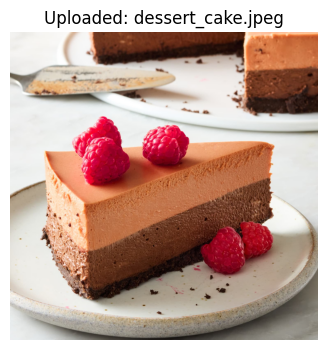

Prediction:
  ✅ dessert: 100.00%
  ✅ hot_dog: 0.00%
  ✅ hamburger: 0.00%
  ✅ kebab: 0.00%


In [12]:
# ----------------------------------------
# Required Imports
# ----------------------------------------
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2
from PIL import Image
from google.colab import files
import io
import matplotlib.pyplot as plt

# ----------------------------------------
# Define Semantic Classes
# ----------------------------------------
CLASSES = ['hamburger', 'hot_dog', 'dessert', 'kebab', 'pilaf']  # Must match training order
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: i for i, cls in enumerate(CLASSES)}

# ----------------------------------------
# Transform for Uploaded Images (no augmentations!)
# ----------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----------------------------------------
# Load Model
# ----------------------------------------
model = mobilenet_v2(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model.load_state_dict(torch.load('/content/menu_detector.pth', map_location='cpu'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model = model.to(device)
model.eval()

# ----------------------------------------
# Upload & Predict
# ----------------------------------------
print("Upload one or more images of your food:")
uploaded = files.upload()

for image_name in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[image_name])).convert('RGB')

    # Display image
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Uploaded: {image_name}')
    plt.show()

    # Predict
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)[0]
        topk = torch.topk(probs, 4)

    print("Prediction:")
    for i in range(topk.indices.size(0)):
        label = CLASSES[topk.indices[i]]
        confidence = topk.values[i].item() * 100
        print(f"  ✅ {label}: {confidence:.2f}%")
